## SMS Spam Detection
#### 2017/8/8 Weiying Wang

This is a complete guide of using language model to perform spam detection. The objective is straightforward: Given a labeled data, where one column is text message, and another column is the label: `spam` or `ham` (i.e. not spam), build a model to detect spam message. The data consists 5572 entries, and 13% of them are spam. The text will be featured using tf-idf.

I will cover most of the machine learning tools, as you can see in the **table of content**. And compare them.

The winner, here, is SVM, who gives acuracy **98.9%** and F1 score 0.957 on the 20% test set, LR, MNB(multinomial Naive Bayes), and RF, are slightly trailed behind.

### Table of Content:

#### 0. Import Data and Module
 
#### 1. From Text To Features
 
#### 2. Prediction
 
    2.1 Support vector classifier
    
    2.2 Naive Bayes
    
    2.3 Decision Tree
    
    2.4 Logistic Regression
    
    2.5 Random Forest
    
    2.6 Adaboost
    
    2.7 Gradient Boost Machine (XGBoost)
    
#### 4. Comparison Between Models
    
    4.1 Accuracy and F1 Score
    
    4.2 Confusion Matrices
    
    4.3 Misclassified samples from SVM

## 0. Import Data and Module

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import string
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
%matplotlib inline

C:\WinPython-64bit-3.6.0.1Qt5\python-3.6.0.amd64\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('../input/spam.csv', encoding='latin-1')
df = df.loc[:,['v1','v2']]
df.tail()

,v1,v2
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


Let's first transform column `v1`, where `ham=0`, `spam=1`.

In [3]:
d={'spam':1,'ham':0}
df.v1 = list(map(lambda x:d[x],df.v1))

I will going to use nltk module, if this is your first time use nltk, please run the following in your Python environment:
```
import nltk
nltk.download()
```
Then you can install all the requirement from the application interface.

## 1. From Text To Features

I am going to use tf-idf model on the text. The text will be 

1. lower: No captal appeared.
2. remove punctuation: No punctuation appeared.
3. stemmed: collect similar words (i.e. `words` will be transformed to `word`,etc.)

The convert the cleaned text to tf-idf features (5000 features for an entry).

In [4]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

class stemmed_tfidf():
    def __init__(self,max_features=5000):
        self.ps = PorterStemmer()
        self.vc = TfidfVectorizer(analyzer='word',#{‘word’, ‘char’}  Whether the feature should be made of word or character n-grams
                             stop_words = 'english',
                             max_features = max_features)
    def tfidf(self,ListStr):
        '''
        return: sklearn.feature_extraction.text.TfidfVectorizer
        '''
        table = self.vc.fit_transform([self.stem_string(s) for s in ListStr])
        return table
    def stem_string(self,s):
        '''
        s:str, e.g. s = "Get strings with string. With. Punctuation?"
        ps: stemmer from nltk module
        return: bag of words.e.g. 'get string with string with punctuat'
        '''    
        s = re.sub(r'[^\w\s]',' ',s)# remove punctuation.
        tokens = word_tokenize(s) # list of words.
        #a = [w for w in tokens if not w in stopwords.words('english')]# remove common no meaning words
        return ' '.join([self.ps.stem(w) for w in tokens])# e.g. 'desks'->'desk'

In [5]:
stf = stemmed_tfidf()
feature = stf.tfidf(df.v2) # this will be a sparse matrix of size (n,5000)

## 2. Prediction

Before doing analysis, we have to decide the metric to compare between different models. The following calculate the percentage of spam data. As you can see, We have an inbalanced data set, in which only about 13% of the data is spam. The way to deal with it is to **increase their weight** (the spam samples) and **use F1 score** instead of accuracy.

In [9]:
print('%2.2f percent of data is spam: We have an inbalanced data set.'%round(100*sum(df.v1)/len(df),2))

13.41 percent of data is spam: We have an inbalanced data set.


To be able to compare between models, we will separate the data set into training and test set. Also,some models requires paramter tunning, one must be careful that all the tunning (cross-validation) should be performed in the training set.

In [10]:
Xtrain, Xtest, ytrain, ytest = train_test_split(feature, df.v1, test_size=0.2, random_state=1)

I will going to use a lot of tools to analysis, and the results will be put into the folloing three dictionary.

In [11]:
Acc = {}
F1score = {}
confusion_mat={}
predictions = {}

### 2.1 Support vector classifier

Several caveat to use SVM:

1. SVM is sensitive to scaling, which is not an issue here since tf-idf generated from `TfidfVectorizer` has already be normalized to 0 and 1.

2. I will use 3-fold (default) cross validation to determine the two hyperparameter `C` anc `gamma`:

 a. `C`:lower C lead to underfitting, and higher C lead to overfit.
 
 b. `gamma`: parameter that controls `rbf`,`poly`, and `sigmoid` kernel. See [SVM document](http://scikit-learn.org/stable/modules/svm.html#svm-classification).
 
The cross validation step is slow, let's split that into two cross validations.

In [22]:
val_scores = []
listc = np.linspace(0.5,3,num=4)
listgamma = np.linspace(0.5,3,num=4)
kernel = ['rbf','sigmoid']# 'poly' is doing bad here, let's save some time.
for v in kernel:
    for c in listc:
        for gamma in listgamma:
            svc = SVC(kernel=v, C=c, gamma=gamma,class_weight='balanced')
            #3. The “balanced” mode uses the values of y to automatically adjust weights inversely 
            #   proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
            scores = cross_val_score(svc, Xtrain, ytrain,scoring='f1')
            val_scores.append([np.mean(scores),v, c,gamma])

In [24]:
val_scores = np.array(val_scores)
print('The best scores happens on:',val_scores[val_scores[:,0]==max(val_scores[:,0]),1:],
      ', where F1 =',val_scores[val_scores[:,0]==max(val_scores[:,0]),0])

The best scores happens on: [['sigmoid' '1.33333333333' '0.5']] , where F1 = ['0.921963729333']


After this we see that `kernel='sigmoid', C=1.3, gamma=0.5]` gives best result in F1 (look at `val_score`). Let's continue to see if any refinement of `C` and `gamma` make it better.

In [27]:
val_scores = []
listc = np.linspace(0.5,2,num=5)
listgamma = np.linspace(0.3,1,num=5)
for c in listc:
    for gamma in listgamma:
        svc = SVC(kernel='sigmoid', C=c, gamma=gamma,class_weight='balanced')
        scores = cross_val_score(svc, Xtrain, ytrain,scoring='f1')
        val_scores.append([np.mean(scores),v, c,gamma])
val_scores = np.array(val_scores)
print('The best scores happens on:',val_scores[val_scores[:,0]==max(val_scores[:,0]),1:],
      ', where F1 =',val_scores[val_scores[:,0]==max(val_scores[:,0]),0])

The best scores happens on: [['sigmoid' '1.25' '0.825']] , where F1 = ['0.924973193278']


After look at the `val_scores`, I decide to use `kernel='sigmoid', C=1.25, gamma=0.825]`, which gives the highest F1 score.

In [28]:
name = 'SVM'
svc = SVC(kernel='sigmoid', C=1.25, gamma=0.825,class_weight='balanced')
svc.fit(Xtrain,ytrain)
pred = svc.predict(Xtest.toarray())
F1score[name]= f1_score(ytest,pred)
Acc[name] = accuracy_score(ytest,pred)
confusion_mat[name] = confusion_matrix(ytest,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

SVM: Accuracy=0.989, F1=0.957


### 2.2 Naive Bayes

You probably heard that Naive Bayes (NB) works surprising well in the text classification. But you still need to be careful.

Since our tf-idf feature is continuous (within 0 and 1), the probability model $P(x_k|y)$  for kth feature will be modeled as Gaussian, i.e. GDA. This will be a **bad idea** since our feature will not look like Gaussian (the value is within 0 and 1). Let's run it anyway, and after that I will tell you **a better way** to do it.

In [223]:
GNB = GaussianNB()
GNB.fit(Xtrain.toarray(), ytrain)# Since our Xtrain is a sparse matrix, need to use .toarray() to convert it to dense one.
accuracy_score(ytest,GNB.predict(Xtest.toarray()))

0.86483253588516751

As you can see, it is not good. Let's use a better way, **multinominal Naive Bayes (MNB)**.

Usually, to apply NB, people **quantize** the continuous feature value and model $P(x_k|y)$ as a multinominal distribution. So we are going to do that. The following gives a simple way to quantize an array, or list of array.

In [214]:
np.digitize([[0.1,0.22,0.33,0.8],[0.1,0.22,0.05,0.8]],bins = [.15,.25])

array([[0, 1, 2, 2],
       [0, 1, 0, 2]], dtype=int64)

In [37]:
bins = [.2,.4,.6,.8] # so every feature will end up 0,1,2,3,4
Xqtrain = np.digitize(Xtrain.toarray(),bins = bins)
Xqtest = np.digitize(Xtest.toarray(),bins = bins)

As SVM, there are tunning parameter in NB for using multinominal distribution here, called the Lapalace smoothing parameter,  `alpha`. Again, we use 3-fold cross validation to decide what `alpha` is.

In [29]:
from sklearn.naive_bayes import MultinomialNB
val_scores = []
listalpha = np.linspace(0.01,1,num=20)
for i in listalpha:
    MNB = MultinomialNB(alpha=i)# alpha is Laplace smoothing parameter
    scores = cross_val_score(MNB, Xtrain, ytrain,scoring='f1')
    val_scores.append([np.mean(scores),i])
val_scores = np.array(val_scores)
print('The best scores happens on:',val_scores[val_scores[:,0]==max(val_scores[:,0]),1:],
      ', where F1 =',val_scores[val_scores[:,0]==max(val_scores[:,0]),0])

The best scores happens on: [[ 0.27052632]] , where F1 = [ 0.93487703]


I will use `alpha = 0.27052632`, which gives the maximum F1 scores among all.

In [30]:
name = 'MNB'
MNB = MultinomialNB(alpha=0.27052632)
MNB.fit(Xtrain,ytrain)
pred = MNB.predict(Xtest.toarray())
F1score[name]= f1_score(ytest,pred)
Acc[name] = accuracy_score(ytest,pred)
confusion_mat[name] = confusion_matrix(ytest,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

MNB: Accuracy=0.987, F1=0.949


This result is much better than using Gaussian NB.

### 2.3 Decision Tree

Decistion Tree(DT) is one of the baseline model for classification. Since it doesn't require scaling, and no need to worry about multicollinearity, it is very easy to apply.

Basically, DT binary splits one of the feature (optimally selected) in each iteration, this partitions feature space. After several iteration, we have a lot of partition in the feature space. The algorithm will first overfit the sample, then use some criterion to 'pruning' the overfitted tree.

An advanced version of DT will be method that use ensumble, i.e. Adaboost, Random Forest, and Gradient Boost Machine, there basic learner are (almost all) DT.

One of the important parameter of DT is `min_samples_split`, an interger value>=1, which determine the sample size in the smallest leaf. We are going to use cross validation to determine that.

In [31]:
val_scores = []
for i in range(2,21):
    DT = DecisionTreeClassifier(min_samples_split=i, random_state=1,class_weight='balanced')
    scores = cross_val_score(DT, Xtrain, ytrain,scoring='f1')
    val_scores.append([np.mean(scores),i])
val_scores = np.array(val_scores)
print('The best scores happens on:',val_scores[val_scores[:,0]==max(val_scores[:,0]),1:],
      ', where F1 =',val_scores[val_scores[:,0]==max(val_scores[:,0]),0])

The best scores happens on: [[ 4.]] , where F1 = [ 0.83111103]


So, I will use `min_samples_split=4`, which gives best F1 score during cross validataion, to run the test set.

In [32]:
name = 'DT'
DT = DecisionTreeClassifier(min_samples_split=4, random_state=1,class_weight='balanced')
DT.fit(Xtrain,ytrain)
pred = DT.predict(Xtest.toarray())
F1score[name]= f1_score(ytest,pred)
Acc[name] = accuracy_score(ytest,pred)
confusion_mat[name] = confusion_matrix(ytest,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

DT: Accuracy=0.968, F1=0.878


### 2.4 Logistic Regression

The most famous model for classification, one of the baseline model. One needs to be care about:
 
 1. If there is multicoliearity, it will affect LR. Since it calculate inverse of (X'X) in the algorithm and strong multicolinearity will make the matrix ill-condition.
 
 2. To prevent overfitting, one usually puts L1 or L2 regularity here. A parameter `C` will help control overfit or not. Smaller `C` leads to underfit and vise versa.

In [33]:
list_C = np.linspace(0.1,3,num=20)
val_scores = []
for p in ('l1','l2'):
    for c in list_C:
        LR = LogisticRegression(penalty=p,C=c,class_weight='balanced')
        scores = cross_val_score(LR, Xtrain, ytrain,scoring='f1')
        val_scores.append([np.mean(scores),p,c])
val_scores = np.array(val_scores)
print('The best scores happens on:',val_scores[val_scores[:,0]==max(val_scores[:,0]),1:],
      ', where F1 =',val_scores[val_scores[:,0]==max(val_scores[:,0]),0])            

The best scores happens on: [['l2' '0.863157894737']] , where F1 = ['0.912843500453']


Let's use the parameter `penalty='l2',C=0.863157894737`

In [34]:
name = 'LR'
LR = LogisticRegression(penalty='l2',C=0.863157894737,class_weight='balanced')
LR.fit(Xtrain,ytrain)
pred = LR.predict(Xtest)
F1score[name]= f1_score(ytest,pred)
Acc[name] = accuracy_score(ytest,pred)
confusion_mat[name] = confusion_matrix(ytest,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

LR: Accuracy=0.987, F1=0.950


### 2.5 Random Forest

Random Forest(RF) is a very popular method. Basically, it will generate several boostrap samples (the number is `n_estimator`, as you will see, the higher of this, the better), and with the boostrap sample, it generate a decision tree. The subtlety is that when deciding the split, it chooses from **subsets** of features to split the tree (This will help prevent overfitting, for example, think about doing some mathematic problem without using some big theorems, if you learn this technique, you will be, or maybe, clever on different kind of harsh environment.) 

So in the end you will get `n_estimator` of trees. The final decision can be made by majority vote from them.

In [35]:
name = 'RF'
RF = RandomForestClassifier(n_estimators =80,class_weight ='balanced')
RF.fit(Xtrain,ytrain)
pred = RF.predict(Xtest)
F1score[name]= f1_score(ytest,pred)
Acc[name] = accuracy_score(ytest,pred)
confusion_mat[name] = confusion_matrix(ytest,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

RF: Accuracy=0.989, F1=0.956


### 2.6 Adaboost

Adaboost is probably the first way using boostrap to enhance the model. The procedure can be described as: given a uniform weight $$w = (w_1,...,w_1)$$

1. Re-sampling a sample set from training set according to the weight w.

2. Use tree (default) or other method to induce a classification rule, say $$f_{m}(x).$$

3. Estimate the training error rate by $$\epsilon_{m}\propto\sum_{i=1}^{n}w_{i}\mathbb{I}_{\{y_{i}\neq f_m(x_{i})\}}.$$

4. For i in correct index set, put the weight down by $$w_{i}=w_{i}\cdot\frac{\epsilon_{m}}{1-\epsilon_{m}}.$$ And normalize the weight, so that incorrect sample will receive higher weight next time.

Repeat 1,2,3,4 for M times, and get M rules,say $$f_{1},\cdots,f_{M}$$. The final master rule is $$sign[\sum_{m=1}^{M}\beta_{m}f_{m}(x)],$$ where $$\beta_{m}=\log(\frac{1-\epsilon_{m}}{\epsilon_{m}}).$$ 

Briefly speaking, 

1. the hard to classified entries will receive more weight when preforming the next boostrap (so they will tend to be drawn more often next time).

2. the weak learner will receive smaller weight when doing the majority vote in the end.

In [36]:
name = 'AdaBoost'
Ada = AdaBoostClassifier(n_estimators=80, random_state=1)
Ada.fit(Xtrain,ytrain)
pred = Ada.predict(Xtest)
F1score[name]= f1_score(ytest,pred)
Acc[name] = accuracy_score(ytest,pred)
confusion_mat[name] = confusion_matrix(ytest,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

AdaBoost: Accuracy=0.984, F1=0.932


### 2.7 Gradient Boost Machine

The Gradient Boost Machine (GBM) is basically:

1. Let fT=0

2. Obtain a boostrap sample set from $$(x_{i},y_{i})_{i=1}^{n}$$

2. Using the Boostrap sample set to build **binary tree** till a certain depth (parameter `max_depth`). The tree is denote as f, or say f(x).

3. Update fT, i.e. fT = fT + f.

4. repeat step 1 again.

And use the final tree fT to do the classification. Note that in step 2, we use binary tree so there is no need to rescale feature values. And no need to worry about multicollinearity. Also note that, in step 3, it renders an **additive** model, where the difficult samples will receive higher weight (inherently) in the next iteration.

The following gives the code for doing cross validataion on XGBoost, a faster and more efficient version of GBM. Note that I didn't try a lot of parameters since it would take too long. Note that it might not give GBM a fair fight here by not finding best parameters here.

In [38]:
data_tr  = xgb.DMatrix(Xtrain, label=ytrain)
val_scores = []
list_max_depth =[6,9,14]
list_subsample = [0.8,1]
for max_depth in list_max_depth:
    for subsample in list_subsample:
        parms = {'max_depth':max_depth, #maximum depth of a tree
                 'objective':'binary:logistic',
                 'eta'      :0.1,
                 'subsample':subsample,#SGD will use this percentage of data
                 'lambda '  :1.5, #L2 regularization term,>1 more conservative
                 'colsample_bytree ':0.8,
                 'nthread'  :3}  #number of cpu core to use
        result = xgb.cv(parms, data_tr, 
                            num_boost_round=1000,
                            early_stopping_rounds=20,# early stop if cv result is not improving
                            nfold=3,metrics="error")
        val_scores.append([result['test-error-mean'].iloc[-1],max_depth,subsample,len(result)-20])
        #len(result) will be our num_boot_round in the test set
val_scores = np.array(val_scores)
print('The best scores happens on:',val_scores[val_scores[:,0]==min(val_scores[:,0]),1:],
      ', where accuracy =',val_scores[val_scores[:,0]==min(val_scores[:,0]),0])

The best scores happens on: [[   9.     0.8  118. ]] , where accuracy = [ 0.02603833]


Let's using the parameter that produce the smallest error. Note that don't apply early stop on the test set, since the `num_boost_round` should only be decided in the training data.

In [39]:
data_tr  = xgb.DMatrix(Xtrain, label=ytrain)
data_val  = xgb.DMatrix(Xtest, label=ytest)
evallist = [(data_tr, 'train'), (data_val, 'test')]

parms = {'max_depth':9, #maximum depth of a tree
         'objective':'binary:logistic',
         'eta'      :0.1,
         'subsample':0.8,#SGD will use this percentage of data
         'lambda '  :1.5, #L2 regularization term,>1 more conservative
         'colsample_bytree ':0.8,
         'nthread'  :3}  #number of cpu core to use

GBM = xgb.train(parms, data_tr, num_boost_round=118, evals = evallist,
                maximize=False, verbose_eval=False)

In [40]:
name = 'GBM'
pred = GBM.predict(xgb.DMatrix(Xtest)) # note that this is float value between 0 and 1. This is the probability of y=1.
pred = [int(round(p)) for p in pred]
F1score[name]= f1_score(ytest,pred)
Acc[name] = accuracy_score(ytest,pred)
confusion_mat[name] = confusion_matrix(ytest,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

GBM: Accuracy=0.984, F1=0.935


Let's save the result for latter use.

In [42]:
'''
import pickle
with open('spam_result.pickle', 'wb') as handle:
    pickle.dump([Acc,F1score,confusion_mat,predictions], handle, protocol=pickle.HIGHEST_PROTOCOL)
'''

"\nimport pickle\nwith open('spam_result.pickle', 'wb') as handle:\n    pickle.dump([Acc,F1score,confusion_mat,predictions], handle, protocol=pickle.HIGHEST_PROTOCOL)\n"

## 4. Comparison Between Models

In [46]:
'''import pickle
with open('spam_result.pickle', 'rb') as handle:
    b = pickle.load(handle)
Acc,F1score,confusion_mat,predictions = b[0],b[1],b[2],b[3]
'''

### 4.1 Accuracy and F1 Score

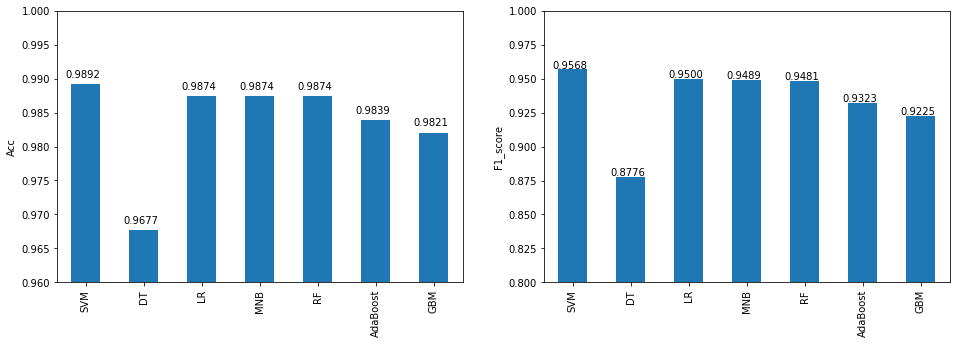

In [125]:
Results = pd.DataFrame([v for v in Acc.values()], columns = ['Acc'],
                    index = [k for k in Acc.keys()])
Results = Results.assign(F1_score=[v for v in F1score.values()])

fig = plt.figure(figsize=(16,5))
ylim = [[0.96,1],[0.8,1]]
x_offset = -0.35; y_offset = 0.001
for i,(a,yl) in enumerate(zip(list(Results.keys()),ylim)):
    plt.subplot(1,2,i+1)
    Results[a].plot(kind='bar')
    plt.ylabel(a); plt.ylim(yl)
    for p in plt.gca().patches:
        b = p.get_bbox()
        val = "{:1.4f}".format(b.y1 + b.y0)        
        plt.gca().annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))


As we can see SVM gives a very good Accuracy and F1 score on the test set, LR,MNB, and RF, are slightly trail behind.

### 4.2 Confusion Matrices

The following code, obtained from [scikit](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html) webpage, plots the confusion matrix.

In [197]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout();plt.ylabel('True label');plt.xlabel('Predicted label')

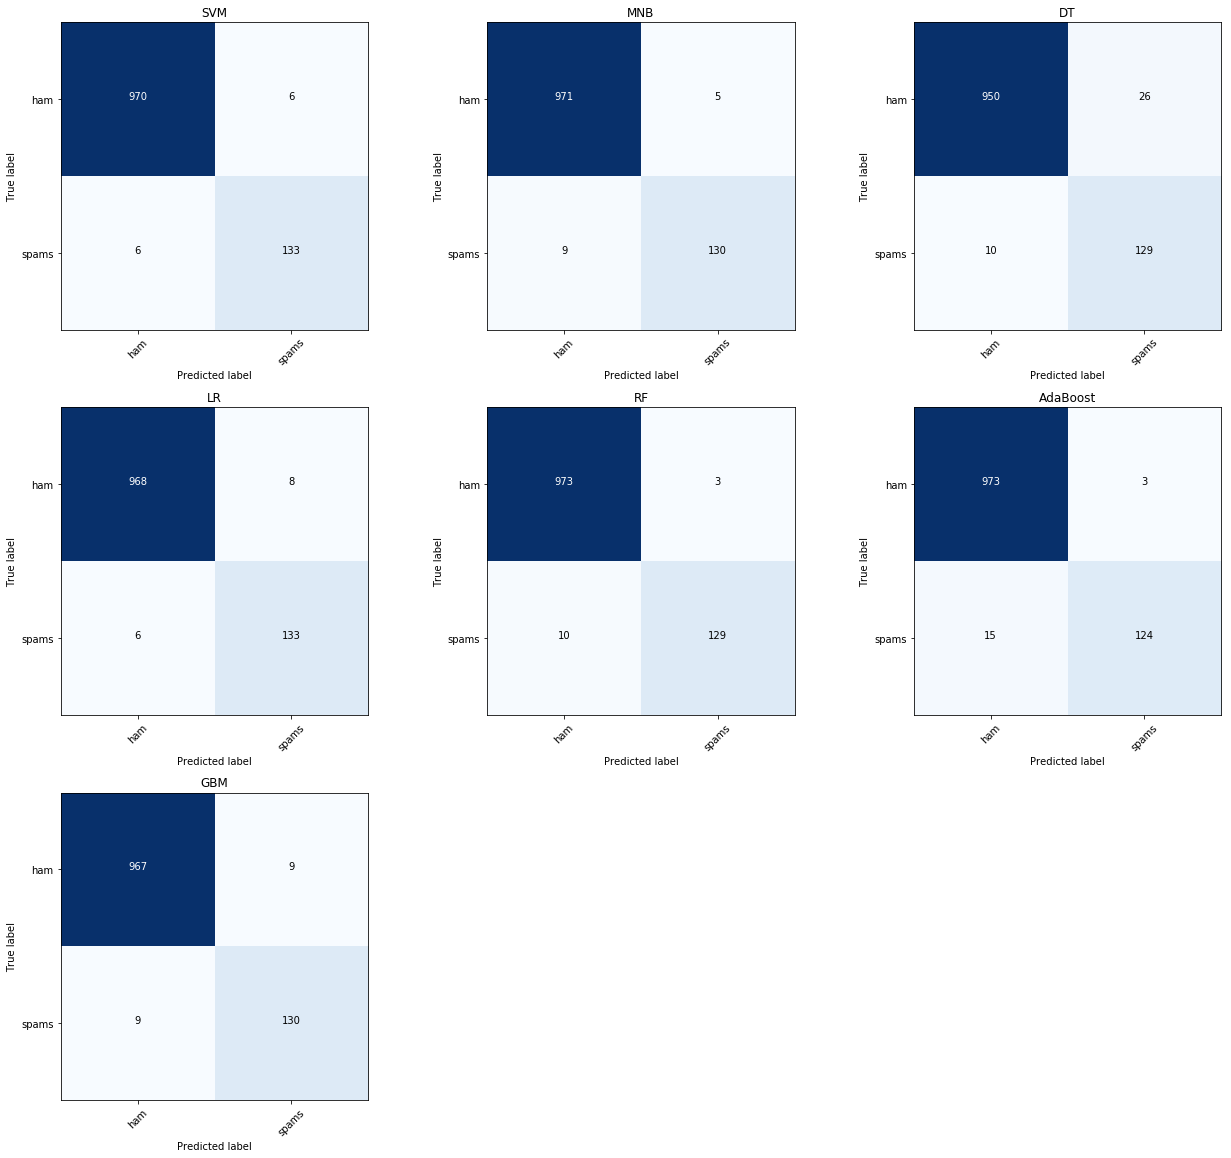

In [198]:
fig = plt.figure(figsize=(18,16))
i=1
for key,val in confusion_mat.items():
    plt.subplot(3,3,i);i+=1
    plot_confusion_matrix(val, classes=['ham','spams'], normalize=False,
                      title=key)

### 4.3 Misclassified samples from SVM

The following code shows the miss-classified text message (model SVM). I can tell some of them are spam, like entry 3528. I guess there is still some place to do better.

In [190]:
missclassified = np.nonzero(pred!=ytest)[0]
ind_miss = ytest.index[missclassified]
df.iloc[ind_miss,:]

,v1,v2
325,0,No calls..messages..missed calls
3528,1,Xmas & New Years Eve tickets are now on sale f...
386,0,Customer place i will call you.
4247,1,"accordingly. I repeat, just text the word ok o..."
3417,1,LIFE has never been this much fun and great un...
2773,1,How come it takes so little time for a child w...
45,0,No calls..messages..missed calls
416,0,Alright i have a new goal now
2950,0,Hey now am free you can call me.
4071,1,Loans for any purpose even if you have Bad Cre...
